# Tutorial for using `align_represenatations.py` 

In [1]:
import os, sys
sys.path.append(os.path.join(os.getcwd(), '../'))

import numpy as np
import pandas as pd
import pickle as pkl

from src.align_representations import Representation, AlignRepresentations, OptimizationConfig, VisualizationConfig

## Load data
you can choose the following data
1. 'DNN': representations of 2000 imagenet images in AlexNet and VGG19
1. 'color': human similarity judgements of 93 colors for 5 paricipants groups
1. 'face': human similarity judgements of 16 faces, attended vs unattended condition in the same participant
1. 'THINGS' : human similarity judgements of 1854 objects for 4 paricipants groups


"data_select" in next code block can define which dataset are going to be used.

In [2]:
data_select = "THINGS"

##### set some parameters used later...

In [3]:
'''
Set Representations
    - A Representation needs a name and either an embedding or a similarity matrix.
'''
# Parameters
n_representations = 4 # Set the number of representations. This number must be equal to or less than the number of groups.
metric = "euclidean"

# representations list that will be used in Align_Representations
representations = list()

### Dataset No1. `color`

In [4]:
# Load data and create representations instance
if data_select == 'color':
    category_mat = None
    data_path = '../data/num_groups_5_seed_0_fill_val_3.5.pickle'
    with open(data_path, "rb") as f:
        data = pkl.load(f)
    sim_mat_list = data["group_ave_mat"]
    for i in range(n_representations):
        name = f"Group{i+1}"
        sim_mat = sim_mat_list[i]
        representation = Representation(name = name, sim_mat = sim_mat)
        representations.append(representation)


### Dataset No.2 `THINGS`

In [5]:
if data_select == "THINGS":
    # define the label information of the dataset
    category_mat = pd.read_csv("../data/category_mat_manual_preprocessed.csv", sep = ",", index_col = 0)
    
    # define the parameters for label info. 
    # Users can define these by themselves if they use a different dataset and the format of parameters are the same.
    from src.utils.utils_functions import get_category_data, sort_matrix_with_categories
    object_labels, category_idx_list, num_category_list, category_name_list = get_category_data(category_mat)
    
    for i in range(n_representations):
        name = f"Group{i+1}"
        embedding = np.load(f"../data/THINGS_embedding_Group{i+1}.npy")[0]
        
        representation = Representation(
            name = name, 
            embedding = embedding, 
            metric = metric, 
            object_labels = object_labels,
            category_name_list = category_name_list,
            category_idx_list = category_idx_list,
            num_category_list = num_category_list,
            func_for_sort_sim_mat = sort_matrix_with_categories
        )
        
        representations.append(representation)

## Set the parameters for the optimazation of GWOT, and the parameters for visualizing matrices

In [6]:

config = OptimizationConfig(
    data_name = data_select, 
    delete_study = False, 
    device = 'cuda',
    to_types = 'torch',
    n_jobs = 6,
    init_plans_list = ['random'],
    num_trial = 4,
    n_iter = 1,
    max_iter = 200,
    sampler_name = 'tpe',
    eps_list = [1, 10], # [1, 10] for THINGS data, [0.02, 0.2] for colors data
    eps_log = True,
    pruner_name = 'hyperband',
    pruner_params = {'n_startup_trials': 1, 
                     'n_warmup_steps': 2, 
                     'min_resource': 2, 
                     'reduction_factor' : 3
                    },
    use_parallel=True, # both for numpy and torch. the parallel computation is done by "ThreadPoolExecutor" from "concurrent" by Python.
    parallel_method="multithread", # "multiprocess" or "multithread". Default is "multithread".
    multi_gpu=[1,2], # "True" : all the GPU installed in your environment, "list (e.g.[0,2,3])"" : cuda:0,2,3, and "False" : single gpu (or cpu for numpy) will use for parallel computation.
)


## Unsupervised alignment between Representations
    - The object has methods for RSA, GW-alignment, evaluation of the alignment and visalization of aligned embeddings.
    - The parameter "shuffle" means a method is applied for a shuffled similarity matrix.

Pair number 0 : Group1 vs Group2
Pair number 1 : Group1 vs Group3
Pair number 2 : Group1 vs Group4
Pair number 3 : Group2 vs Group3
Pair number 4 : Group2 vs Group4
Pair number 5 : Group3 vs Group4


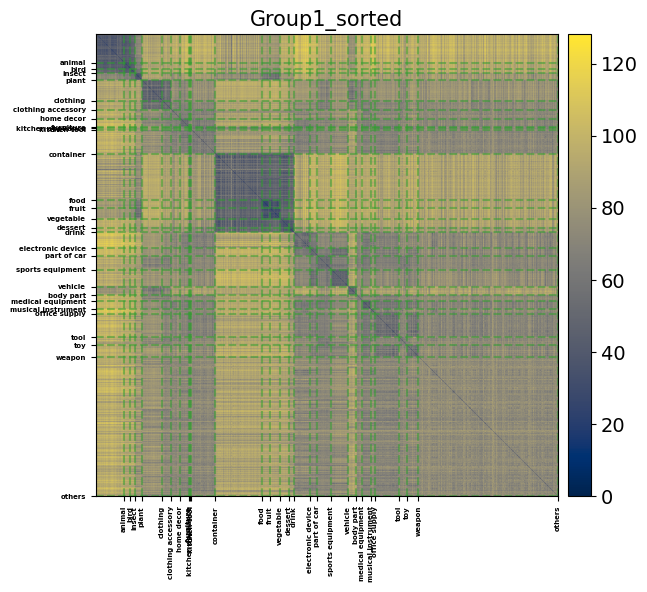

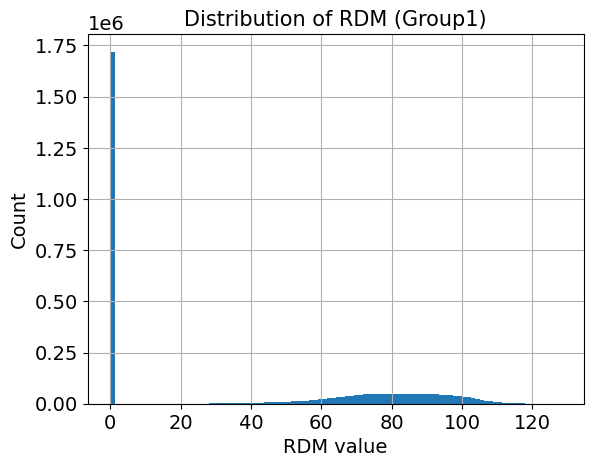

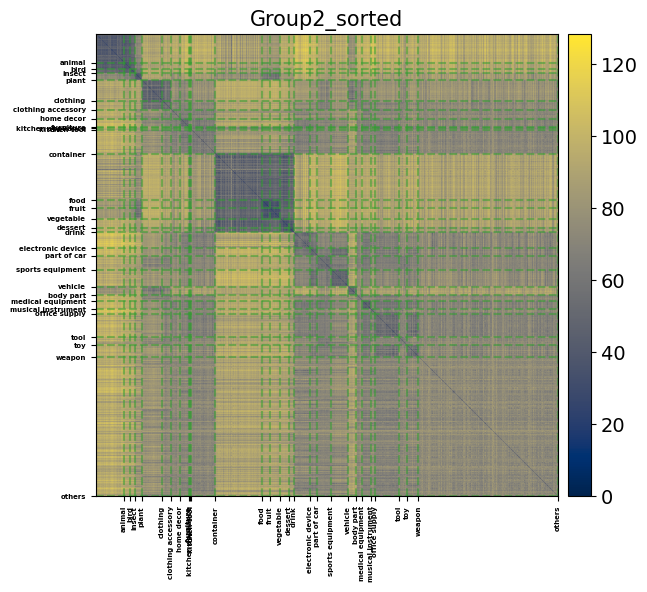

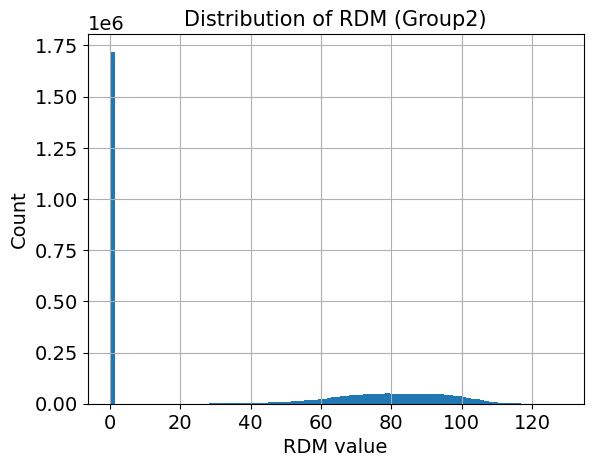

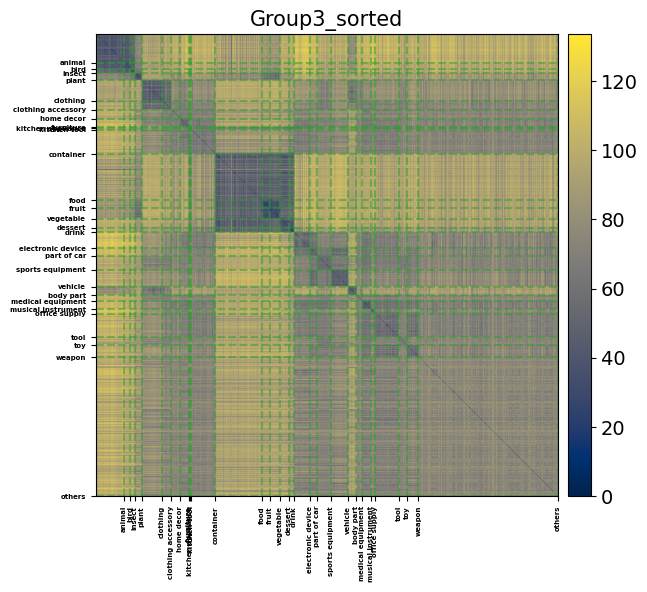

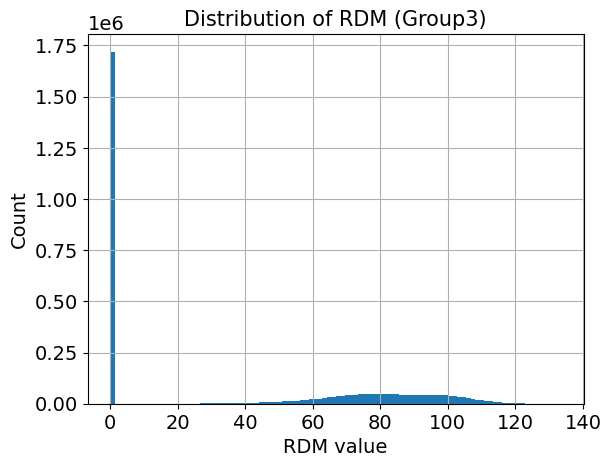

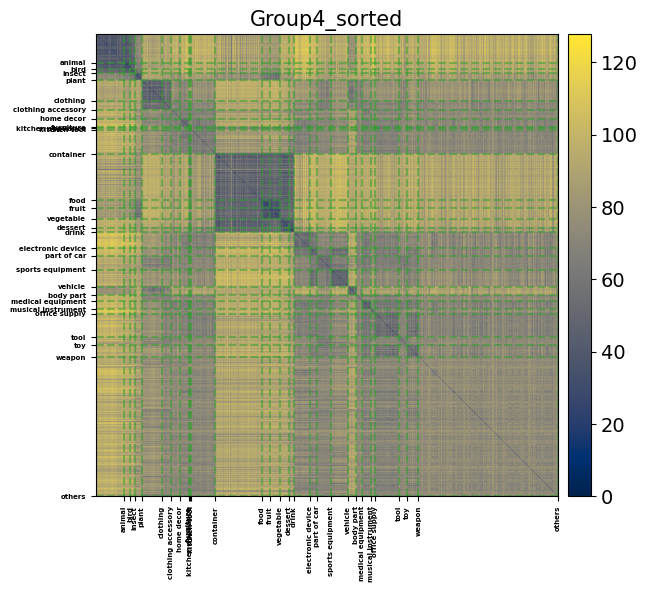

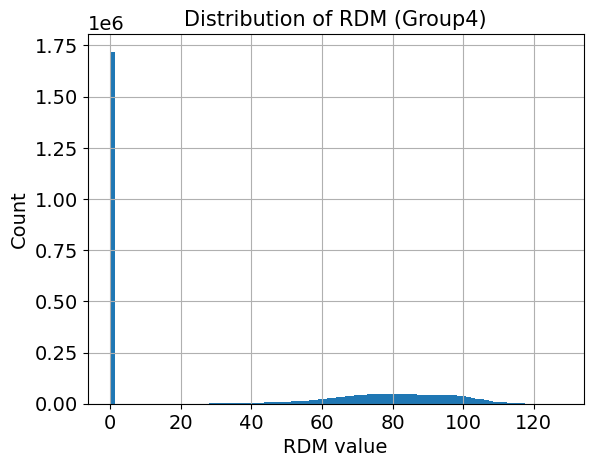

In [7]:

# Set the instance
align_representation = AlignRepresentations(representations_list = representations, config = config)

# RSA
if data_select == "THINGS":
    sim_mat_format = "sorted"
    visualize_matrix = VisualizationConfig(figsize=(8, 6), title_size = 15, category_line_alpha = 0.5, draw_category_line=True)
    sim_mat = align_representation.show_sim_mat(
        sim_mat_format = sim_mat_format, 
        visualization_config = visualize_matrix,
        ticks='category'
    )

if data_select == "color":
    sim_mat_format = "default"
    visualize_matrix = VisualizationConfig(figsize=(8, 6), title_size = 15)
    sim_mat = align_representation.show_sim_mat(
        sim_mat_format = sim_mat_format, 
        visualization_config = visualize_matrix,
    )
    

In [8]:
align_representation.RSA_get_corr(method = 'all')

Correlation Group1 vs Group2 : 0.9716707406871206
Correlation Group1 vs Group3 : 0.9729544775232961
Correlation Group1 vs Group4 : 0.9713401600259295
Correlation Group2 vs Group3 : 0.9727578743253124
Correlation Group2 vs Group4 : 0.9720668542072827
Correlation Group3 vs Group4 : 0.9737002908939038


## Computing GW Alignment.

[I 2023-06-11 21:00:39,681] A new study created in RDB with name: THINGS Group1 vs Group2


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2023-06-11 21:00:40,145] A new study created in RDB with name: THINGS Group1 vs Group3
[I 2023-06-11 21:00:40,557] A new study created in RDB with name: THINGS Group1 vs Group4


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2023-06-11 21:00:41,073] A new study created in RDB with name: THINGS Group2 vs Group3


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2023-06-11 21:00:41,572] A new study created in RDB with name: THINGS Group2 vs Group4


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2023-06-11 21:00:42,093] A new study created in RDB with name: THINGS Group3 vs Group4


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[I 2023-06-11 21:02:17,834] Trial 0 finished with value: 15.428993801399194 and parameters: {'eps': 2.368863950364078, 'initialize': 'random'}. Best is trial 0 with value: 15.428993801399194.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2023-06-11 21:02:18,666] Trial 0 finished with value: 15.45336151440739 and parameters: {'eps': 2.368863950364078, 'initialize': 'random'}. Best is trial 0 with value: 15.45336151440739.
[I 2023-06-11 21:02:18,669] Trial 0 finished with value: 23.86478214478643 and parameters: {'eps': 2.368863950364078, 'initialize': 'random'}. Best is trial 0 with value: 23.86478214478643.
[I 2023-06-11 21:02:18,663] Trial 0 finished with value: 15.083781119956537 and parameters: {'eps': 2.368863950364078, 'initialize': 'random'}. Best is trial 0 with value: 15.083781119956537.


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[I 2023-06-11 21:02:19,471] Trial 0 finished with value: 18.37883239702903 and parameters: {'eps': 2.368863950364078, 'initialize': 'random'}. Best is trial 0 with value: 18.37883239702903.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2023-06-11 21:02:36,980] Trial 0 finished with value: 21.097537643192467 and parameters: {'eps': 2.368863950364078, 'initialize': 'random'}. Best is trial 0 with value: 21.097537643192467.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2023-06-11 21:03:00,774] Trial 1 finished with value: 21.844962371196324 and parameters: {'eps': 8.927180304353628, 'initialize': 'random'}. Best is trial 0 with value: 15.428993801399194.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2023-06-11 21:03:01,364] Trial 1 finished with value: 29.632083011813908 and parameters: {'eps': 8.927180304353628, 'initialize': 'random'}. Best is trial 0 with value: 23.86478214478643.
[I 2023-06-11 21:03:01,558] Trial 1 finished with value: 21.433090300389377 and parameters: {'eps': 8.927180304353628, 'initialize': 'random'}. Best is trial 0 with value: 15.083781119956537.
[I 2023-06-11 21:03:01,585] Trial 1 finished with value: 22.13214517437781 and parameters: {'eps': 8.927180304353628, 'initialize': 'random'}. Best is trial 0 with value: 15.45336151440739.


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[I 2023-06-11 21:03:02,209] Trial 1 finished with value: 25.09603665843499 and parameters: {'eps': 8.927180304353628, 'initialize': 'random'}. Best is trial 0 with value: 18.37883239702903.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2023-06-11 21:03:19,185] Trial 1 finished with value: 26.67506428131792 and parameters: {'eps': 8.927180304353628, 'initialize': 'random'}. Best is trial 0 with value: 21.097537643192467.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2023-06-11 21:03:43,744] Trial 2 finished with value: 17.29036181726286 and parameters: {'eps': 5.395030966670228, 'initialize': 'random'}. Best is trial 0 with value: 15.428993801399194.
[I 2023-06-11 21:03:44,044] Trial 2 finished with value: 25.38060082763477 and parameters: {'eps': 5.395030966670228, 'initialize': 'random'}. Best is trial 0 with value: 23.86478214478643.


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[I 2023-06-11 21:03:44,426] Trial 2 finished with value: 17.420682197974322 and parameters: {'eps': 5.395030966670228, 'initialize': 'random'}. Best is trial 0 with value: 15.45336151440739.
[I 2023-06-11 21:03:44,738] Trial 2 finished with value: 16.828534778727025 and parameters: {'eps': 5.395030966670228, 'initialize': 'random'}. Best is trial 0 with value: 15.083781119956537.


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[I 2023-06-11 21:03:45,301] Trial 2 finished with value: 20.407411287224733 and parameters: {'eps': 5.395030966670228, 'initialize': 'random'}. Best is trial 0 with value: 18.37883239702903.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2023-06-11 21:04:01,612] Trial 2 finished with value: 22.630778787020294 and parameters: {'eps': 5.395030966670228, 'initialize': 'random'}. Best is trial 0 with value: 21.097537643192467.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2023-06-11 21:04:26,953] Trial 3 finished with value: 24.54881755579753 and parameters: {'eps': 3.968793330444372, 'initialize': 'random'}. Best is trial 0 with value: 23.86478214478643.
[I 2023-06-11 21:04:27,662] Trial 3 finished with value: 16.17718746442718 and parameters: {'eps': 3.968793330444372, 'initialize': 'random'}. Best is trial 0 with value: 15.428993801399194.
[I 2023-06-11 21:04:27,963] Trial 3 finished with value: 16.301637084691528 and parameters: {'eps': 3.968793330444372, 'initialize': 'random'}. Best is trial 0 with value: 15.45336151440739.
[I 2023-06-11 21:04:28,340] Trial 3 finished with value: 15.77271201918672 and parameters: {'eps': 3.968793330444372, 'initialize': 'random'}. Best is trial 0 with value: 15.083781119956537.
[I 2023-06-11 21:04:34,000] Trial 3 finished with value: 21.748075383998167 and parameters: {'eps': 3.968793330444372, 'initialize': 'random'}. Best is trial 0 with value: 21.097537643192467.
[I 2023-06-11 21:04:34,420] Trial 3 finished 

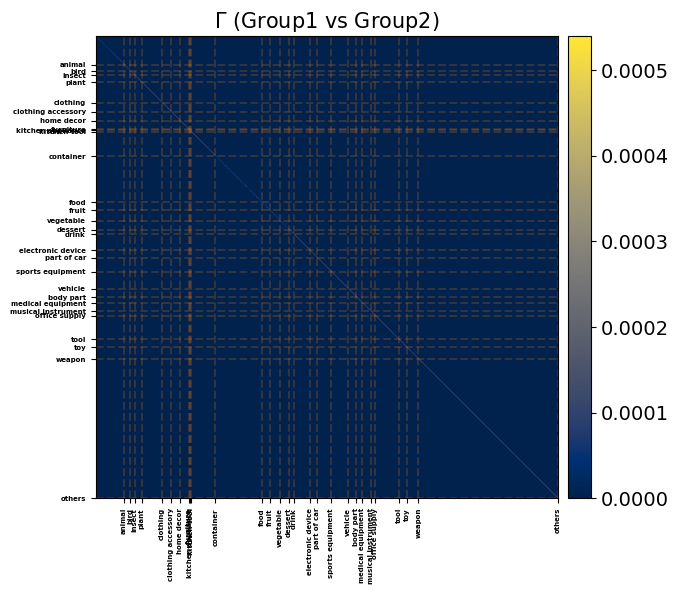

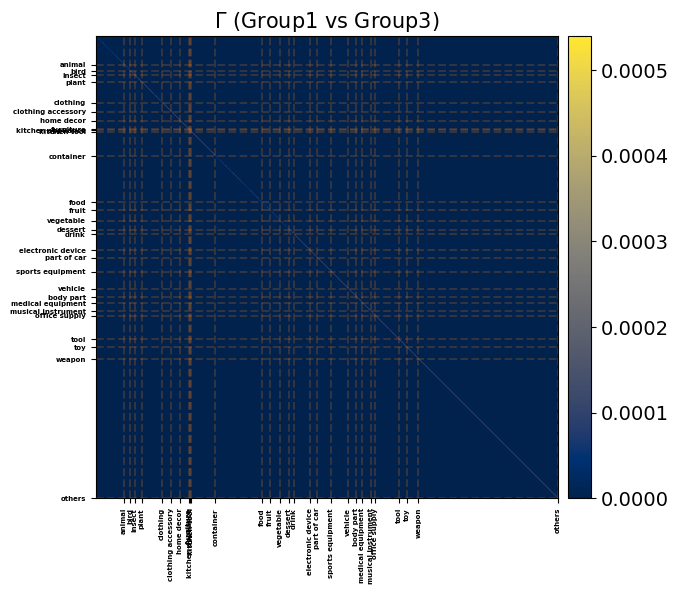

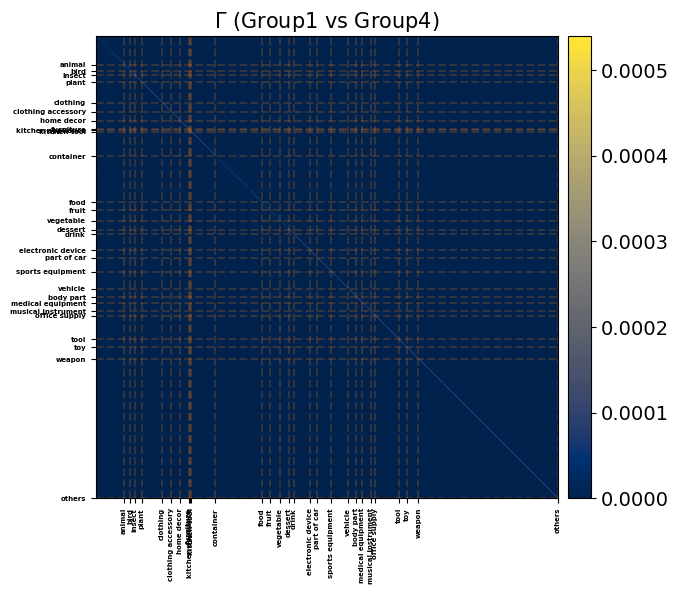

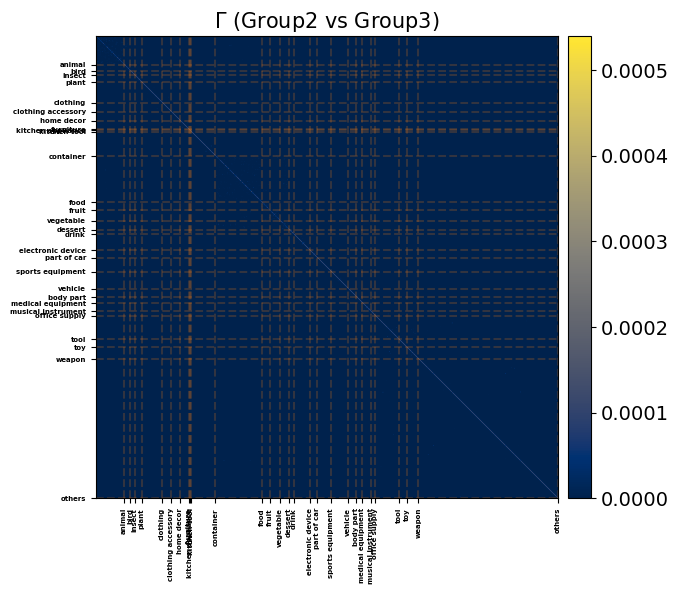

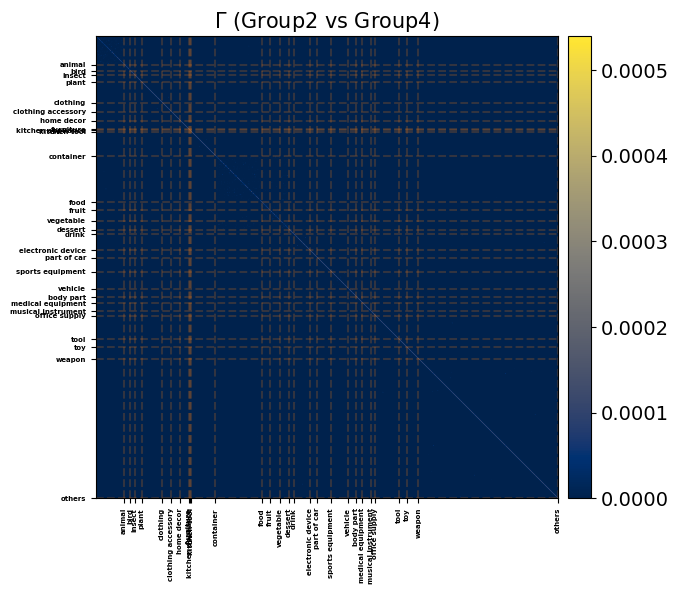

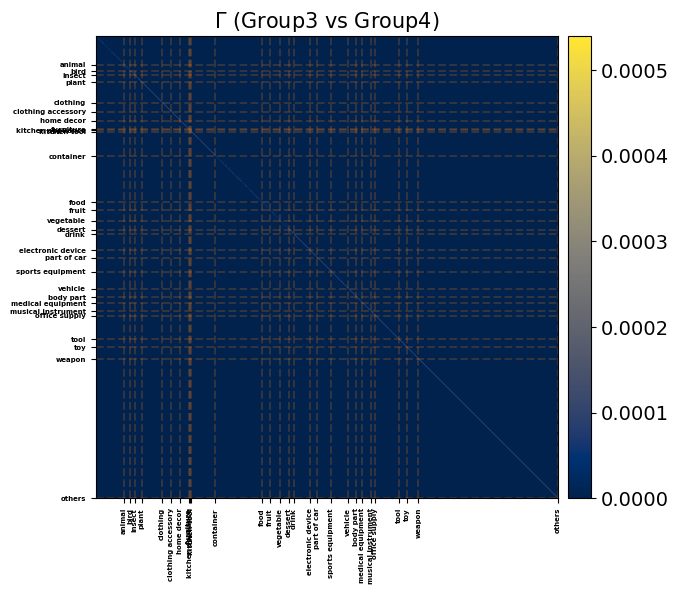

In [9]:
if data_select == "THINGS":
    sim_mat_format = "sorted"
    visualize_matrix = VisualizationConfig(figsize=(8, 6), title_size = 15, category_line_color = 'C1')

    ot_list = align_representation.gw_alignment(
        results_dir = "../results",
        compute_OT = False,  # If the computation was done and no need for, turn "compute_OT" False, then OT plans calculated before is loaded.
        return_data = False,
        return_figure = True,
        OT_format = sim_mat_format, 
        visualization_config = visualize_matrix,
        ticks = 'category', # you can use "objects" or "category" or "None"
    )

if data_select == "color":
    visualize_matrix = VisualizationConfig(figsize=(10, 10), title_size = 15)

    align_representation.gw_alignment(
        results_dir = "../results",
        compute_OT = False,
        return_data = False,
        return_figure = True,
        OT_format = sim_mat_format, # "default"
        visualization_config = visualize_matrix,
    )

## Align embeddings with OT plans and Visualize the aligned embeddings

Top k accuracy : 
        Group1 vs Group2  Group1 vs Group3  Group1 vs Group4  Group2 vs Group3  \
top_n                                                                           
1             89.967638         88.349515         86.623517         88.619202   
5             97.303128         96.763754         96.548004         96.709817   
10            98.651564         98.220065         98.274002         98.543689   

       Group2 vs Group4  Group3 vs Group4  
top_n                                      
1             89.644013         87.324703  
5             97.033441         96.224380  
10            98.381877         97.734628  
Mean : 
 top_n
1     88.112190
5     96.655879
10    98.230852
dtype: float64


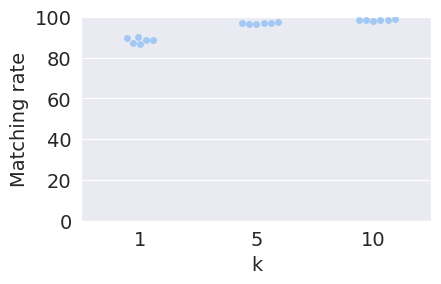

In [10]:
## Calculate the accuracy of the optimized OT matrix
align_representation.calc_accuracy(top_k_list = [1, 5, 10], eval_type = "ot_plan")
align_representation.plot_accuracy(eval_type = "ot_plan", scatter = True)

K nearest matching rate : 
        Group1 vs Group2  Group1 vs Group3  Group1 vs Group4  Group2 vs Group3  \
top_n                                                                           
1             78.586839         76.860841         78.425027         74.865156   
5             94.282632         92.448759         93.635383         92.179072   
10            97.303128         95.846818         96.494067         95.469256   

       Group2 vs Group4  Group3 vs Group4  
top_n                                      
1             77.076591         78.640777  
5             92.826321         93.635383  
10            96.278317         96.386192  
Mean : 
 top_n
1     77.173679
5     92.944984
10    96.094930
dtype: float64


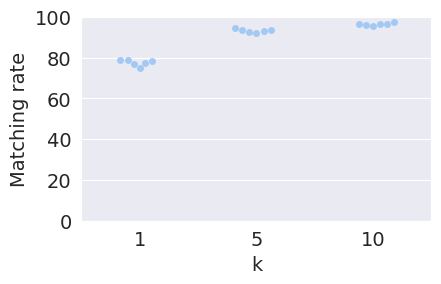

In [11]:
## Calculate the matching rate of k-nearest neighbors of embeddings
## Matching rate of k-nearest neighbors 
align_representation.calc_accuracy(top_k_list = [1, 5, 10], eval_type = "k_nearest")
align_representation.plot_accuracy(eval_type = "k_nearest", scatter = True)

## category level analysis 
User can use this analysis if the dataset has category info.

In [12]:
## Calclate the category level accuracy
if data_select == "THINGS":
    align_representation.calc_category_level_accuracy(category_mat=category_mat)

Group1 vs Group2 :  97.24919093851133
Group1 vs Group3 :  97.14131607335491
Group1 vs Group4 :  96.60194174757282
Group2 vs Group3 :  97.24919093851133
Group2 vs Group4 :  97.24919093851133
Group3 vs Group4 :  96.87162891046385


           Number
bird           25
insect         17
plant          28
clothing       82
furniture      33
fruit          33
drink          19
vehicle        67


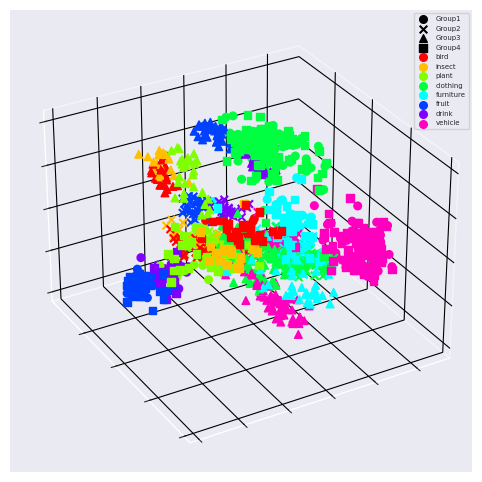

In [13]:
# Set color labels and category data if exist.
if data_select == "THINGS":
    category_name_list = ["bird", "insect", "plant", "clothing",  "furniture", "fruit", "drink", "vehicle"]
    category_mat = pd.read_csv("../data/category_mat_manual_preprocessed.csv", sep = ",", index_col = 0)   
    object_labels, category_idx_list, num_category_list, category_name_list = get_category_data(category_mat, category_name_list, show_numbers = True)  
    
    align_representation.visualize_embedding(
        dim = 3,  
        category_name_list = category_name_list, 
        category_idx_list = category_idx_list, 
        num_category_list = num_category_list,
    )